In [2]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rc('font', size=8)
pd.set_option('display.max_columns', None)


symbols = ('x','.','o','v')

In [2]:
def load_data_orig(fname='pwh_data_orig.csv'):
    return pd.read_csv(fname,
                    parse_dates=["egain_installation"])

def load_data_with_predictions(fname='building_data_prediction_ag_13mins.csv', covid_years=True):
    
    df = load_data_orig()
    
    results_df = pd.read_csv(fname)

    
    results_df = pd.merge(df,results_df[['OID','year','autogluon_prediction']],
            how='left',left_on=['OID','year'],right_on=['OID','year'])

    # exclude outliers with heating turned off
    results_df['energy_per_sqm'] = (results_df['kWh'] * results_df['KF'])/results_df['area']
    results_df = results_df[results_df['energy_per_sqm'] > 10]
    
    # climate correct consumption before computing eco scores
    results_df['energy_per_sqm'] = (results_df['kWh'] * results_df['KF'])/results_df['area']
    
    # translate category names
    results_df['kategorie'] = results_df['kategorie'].replace({'OSZ':'School','FW':'Fire Dept.','PZ':'Police','Kultur':'Culture'})
    # drop unneccessary columns
    results_df = results_df.drop(['flaeche','bbsr_unbereinigt','hzg_kWh','ww_kWh','verbrauch_kWh','f_flaeche'],axis=1)

    if not covid_years:
        results_df = results_df[results_df['year'].isin([2020,2021])==False]
    
    results_df['prediction_bbsr'] = results_df['f_ANGF'] * results_df['area'] * (results_df['TEK_HZG'] + results_df['TEK_HZG'])

    groups = results_df.groupby(['has_egain','kategorie']).agg({'energy_per_sqm':'mean'})
    eco_scores = (groups.unstack().loc[True,:] / groups.unstack().loc[False,:]).unstack().T

    for egain, category in groups.index:
        idx = (results_df['has_egain'] == egain) & (results_df['kategorie'] == category)
        results_df.loc[idx,'prediction_bbsr_a'] = results_df.loc[idx,'prediction_bbsr'] * eco_scores.loc[category,'energy_per_sqm']
        results_df.loc[idx,'prediction_bbsr_o'] =  groups.loc[(egain, category),'energy_per_sqm'] * results_df['area'] 

    results_df['autogluon_prediction'] = results_df['autogluon_prediction'] * results_df['KF']
    results_df['prediction_bbsr_a'] = results_df['prediction_bbsr_a'] # no KF correction, as the predictions are corrected already * results_df['KF']
    results_df['prediction_bbsr_o'] = results_df['prediction_bbsr_o'] # * results_df['KF']
    

    return results_df


In [3]:
df = load_data_with_predictions()
df

,area,kWh,year,OID,objektname,plz,energietraeger,kategorie,f_ANGF,TEK_HZG,TEK_WW,egain_installation,TM,SO,NM,FM,RFM,KF,kWh_bereinigt,egain_year,has_egain,remove,MWh/a,autogluon_prediction,energy_per_sqm,prediction_bbsr,prediction_bbsr_a,prediction_bbsr_o
0,7700.0,861376.140000,2021,217601,OSZ Marktstraße 2-3,10317,erdgas,School,0.931459,49.3,22.4,2018-01-01,6.034553,3.098236,0.0,3.750407,76.978943,1.080375,930609.401010,2018,True,False,0.930609,815234.428705,120.858364,707182.031552,771735.054728,793494.429752
1,6765.0,751964.125695,2021,218946,OSZ Ostpreußendamm 40,12207,erdgas,School,0.950128,49.3,22.4,2018-09-23,6.034553,3.098236,0.0,3.750407,76.978943,1.080375,812403.376525,2019,True,False,0.812403,800398.922025,120.089191,633762.898634,691614.073097,697141.534711
2,4482.0,469192.770000,2021,218968,OSZ Pappelallee 30-31 Schule,10437,erdgas,School,1.013073,49.3,22.4,2019-01-20,6.034553,3.098236,0.0,3.750407,76.978943,1.080375,506904.222641,2019,True,False,0.506904,386695.446516,113.097774,447702.694220,488569.912428,461875.588850
3,1422.0,111645.030073,2021,218972,OSZ Goltzstr. 43-44 OSZ,10781,erdgas,School,1.221097,49.3,22.4,2018-10-02,6.034553,3.098236,0.0,3.750407,76.978943,1.080375,120618.519294,2019,True,False,0.120619,146935.226936,84.823150,171209.026426,186837.336759,146538.841442
4,1587.0,247031.910000,2021,220065,"Fw Alt-Karow 10,11 FW",13125,erdgas,Fire Dept.,1.198911,50.8,7.1,2020-03-02,6.034553,3.098236,0.0,3.750407,76.978943,1.080375,266887.143862,2020,True,False,0.266887,270397.509696,168.170853,193311.470173,154444.300508,220255.367271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,1395.0,141089.362518,2015,232587,"OSZ Niederwallstr. 6,7 Vorderhaus",10117,fernwaerme,School,1.225025,49.3,22.4,2020-02-01,7.644141,3.818824,0.0,3.870916,76.791793,1.130000,159430.979645,2020,False,False,0.159431,NaN,114.287441,168498.515785,183879.405159,131731.717590
605,3694.0,198308.392617,2015,222057,Fw Götelstraße 112,13595,erdgas,Fire Dept.,1.044616,50.8,7.1,2019-05-27,7.644141,3.818824,0.0,3.870916,76.791793,1.130000,224088.483657,2019,False,False,0.224088,NaN,60.662827,392055.186657,313228.640854,641700.240849
606,2812.0,461255.227752,2015,222065,Fw Heinsestraße 24,13467,erdgas,Fire Dept.,1.091410,50.8,7.1,2018-06-01,7.644141,3.818824,0.0,3.870916,76.791793,1.130000,521218.407360,2018,False,False,0.521218,NaN,185.355052,311814.922408,249121.469803,488484.319780
609,3500.0,281894.343259,2015,222829,OSZ Erbeskopfweg 6-10,13158,erdgas,School,1.053653,49.3,22.4,2018-01-01,7.644141,3.818824,0.0,3.870916,76.791793,1.130000,318540.607883,2018,False,False,0.318541,NaN,91.011602,363615.508303,396807.076085,330509.685710


# Data and Features

The data frame contains for a number of public buildings (unique ids are in column ``OID``) the energy consumption (`kWh`) per year for heating and warm water. 

There are a number of building features, such as area, building type (also pseudonymized), as well as a number of features that characterise the year, such as the number of sun hours. 

The column ``verbrauch_kWh`` contains the predicted energy consumption computed with a simple but [effective model provided by the BBSR](https://www.bbsr.bund.de/BBSR/DE/veroeffentlichungen/bbsr-online/2019/bbsr-online-20-2019.html). 


# Predict Building Consumption with e-gain

The goal is to predict the energy savings for each building after installing a system for weather guided heating control. The system installed is called ``e-gain``. 

We can use the autoML package ``autogluon`` for a simple prototype. 

In [4]:

import warnings
warnings.filterwarnings("ignore")

if False:
    label='kWh'
    features=['OID', 
              'energietraeger',
              'area',
              'kWh',
              'kategorie',
              'year',
              'TM',
              'SO',
              'NM',
              'FM',
              'RFM'
             ]

    results = []

    for building in df['OID'].unique():

        train_df = df[(df['OID'] != building) | ((df['OID'] == building) & (df['has_egain'] == False))]
        test_df = df[(df['OID'] == building) & (df['has_egain'] == True)]
        if len(test_df) > 0:
            pred = TabularPredictor(label=label,
                             problem_type='regression',
                             verbosity=0)\
                              .fit(train_data=train_df[features],
                                                        verbosity=0, time_limit=300,
                                      presets='best_quality')
            new_df = test_df.copy()
            new_df['autogluon_prediction'] = pred.predict(test_df).copy()
            results.append(new_df)
            print(new_df)

    results_df = pd.concat(results)


    mape_ag = mean_absolute_error(results_df['kWh'],results_df['autogluon_prediction'])
    mape_din = mean_absolute_error(results_df['kWh'],results_df['prediction_bbsr_a'])
    mape_bbsr = mean_absolute_error(results_df['kWh'],results_df['prediction_bbsr_o'])

    print(f'MAE autogluon {mape_ag:0.2f}, MAPE DIN {mape_din:0.2f}, MAPE bbsr-cv {mape_bbsr:0.2f}')

    mape_ag_kf = mean_absolute_error(results_df['kWh_bereinigt'],results_df['autogluon_prediction'] * results_df['KF'])
    mape_din_kf = mean_absolute_error(results_df['kWh_bereinigt'],results_df['prediction_bbsr_a'] * results_df['KF'])
    mape_bbsr_kf = mean_absolute_error(results_df['kWh_bereinigt'],results_df['prediction_bbsr_o'] * results_df['KF'])


    print(f'KF: MAE autogluon {mape_ag_kf:0.2f}, MAPE DIN {mape_din_kf:0.2f}, MAPE bbsr-cv {mape_bbsr_kf:0.2f}')


    pd.merge(df.drop('autogluon_prediction', axis=1),results_df[['OID','year','autogluon_prediction']],
            how='left',left_on=['OID','year'],right_on=['OID','year']).to_csv('building_data_prediction_new_.csv',index=False)




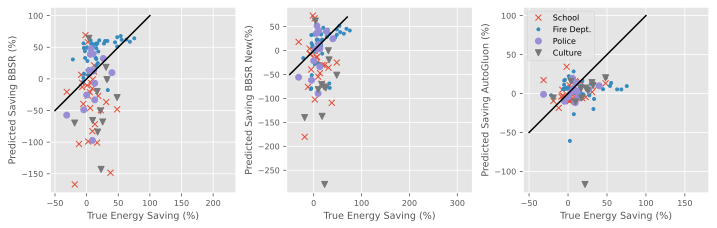

In [5]:
df = load_data_with_predictions()

energy_savings = []
for building_id in df['OID'].unique():
    if len(df.loc[(df['OID']==building_id) & (df['has_egain']==False),'kWh_bereinigt']) > 0:
        consumption_with_egain = df.loc[(df['OID']==building_id) 
                                    & (df['has_egain']==True),'kWh_bereinigt'].median()
        consumption_without_egain = df.loc[(df['OID']==building_id) 
                                    & (df['has_egain']==False),'kWh_bereinigt'].median()
        predicted_consumption_with_egain_ag = df.loc[(df['OID']==building_id) 
                                    & (df['has_egain']==True),'autogluon_prediction'].median()
        predicted_consumption_with_egain_bbsr_a = df.loc[(df['OID']==building_id) 
                                    & (df['has_egain']==True),'prediction_bbsr_a'].median()
        predicted_consumption_with_egain_bbsr_o = df.loc[(df['OID']==building_id) 
                                    & (df['has_egain']==True),'prediction_bbsr_o'].median()
        energy_savings.append(
            {'OID':building_id,
             'category':df.loc[(df['OID']==building_id),'kategorie'].values[0],
             'consumption_with_egain': consumption_with_egain,
             'consumption_without_egain': consumption_without_egain,
             'predicted_consumption_with_egain_ag': predicted_consumption_with_egain_ag,
             'predicted_consumption_with_egain_bbsr_a': predicted_consumption_with_egain_bbsr_a,
             'predicted_consumption_with_egain_bbsr_o': predicted_consumption_with_egain_bbsr_o
            }
        )
df_savings = pd.DataFrame(energy_savings)
df_savings = df_savings.dropna(subset=['consumption_with_egain'])
df_savings['true_saving'] = 100 - 100 * df_savings['consumption_with_egain'] / df_savings['consumption_without_egain']
df_savings['predicted_saving_ag'] = 100 - 100 * df_savings['predicted_consumption_with_egain_ag'] / df_savings['consumption_without_egain']
df_savings['predicted_saving_bbsr_a'] = 100 - 100 * df_savings['predicted_consumption_with_egain_bbsr_a'] / df_savings['consumption_without_egain']
df_savings['predicted_saving_bbsr_o'] = 100 - 100 * df_savings['predicted_consumption_with_egain_bbsr_o'] / df_savings['consumption_without_egain']

plt.figure(figsize=(10,8))
# lim = 2
plt.subplot(1,3,1)
for sym, cat in zip(symbols, df_savings['category'].unique()):
    idx = df_savings['category'] == cat
    plt.plot(df_savings.loc[idx,'true_saving'], df_savings.loc[idx,'predicted_saving_bbsr_a'],sym)
plt.axis('square')

# plt.plot(df_savings.loc[idx, 'true_saving'], df_savings.loc[:, 'predicted_saving_bbsr_a'],sym)
# plt.axis('square')
plt.plot([-50,100],[-50,100],'k-')
plt.ylim([-150,70])
plt.xlim([-30,70])

plt.axis('square')
plt.xlabel('True Energy Saving (%)')
plt.ylabel('Predicted Saving BBSR (%)')

plt.subplot(1,3,2)
# plt.plot(df_savings['true_saving'],df_savings['predicted_saving_bbsr_o'],'.')
for sym, cat in zip(symbols, df_savings['category'].unique()):
    idx = df_savings['category'] == cat
    plt.plot(df_savings.loc[idx,'true_saving'], df_savings.loc[idx,'predicted_saving_bbsr_o'],sym)

# lim = 1.9e6
plt.plot([-50,70],[-50,70],'k-')
plt.ylim([-150,70])
plt.xlim([-30,70])

plt.axis('square')
plt.xlabel('True Energy Saving (%)')
plt.ylabel('Predicted Saving BBSR New(%)')

plt.subplot(1,3,3)
for sym, cat in zip(symbols, df_savings['category'].unique()):
    idx = df_savings['category'] == cat
    plt.plot(df_savings.loc[idx,'true_saving'], df_savings.loc[idx,'predicted_saving_ag'],sym)

plt.plot([-50,100],[-50,100],'k-')
plt.ylim([-150,70])
plt.xlim([-30,70])
# plt.plot(df_savings['true_saving'],df_savings['predicted_saving_ag'],'.')
plt.axis('square')
# lim = 1.9e6
plt.legend(df_savings['category'].unique())
plt.xlabel('True Energy Saving (%)')
plt.ylabel('Predicted Saving AutoGluon (%)')

plt.tight_layout()

Saving prediction errors per category

\begin{tabular}{lrrr}
\toprule
{} &  BBSR-O &  BBSR-A &  AutoML \\
category   &         &         &         \\
\midrule
School     &      45 &      52 &      14 \\
Fire Dept. &      24 &      28 &      22 \\
Police     &      30 &      32 &      12 \\
Culture    &     108 &      70 &      29 \\
Mean       &      41 &      40 &      19 \\
\bottomrule
\end{tabular}

Savings per category

\begin{tabular}{lrrrr}
\toprule
{} &  predicted\_saving\_bbsr\_a &  predicted\_saving\_bbsr\_o &  predicted\_saving\_ag &  true\_saving \\
category   &                          &                          &                      &              \\
\midrule
Culture    &               -50.576410 &               -76.087143 &             6.336564 &    21.785115 \\
Fire Dept. &                49.195560 &                22.387667 &             5.954486 &    14.440102 \\
Police     &                 9.839778 &                 3.602667 &             2.891458 &     9.220615 \\


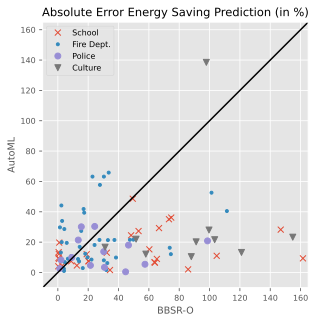

In [6]:
mae_percent_per_category = []

for sym, cat in zip(symbols, df_savings['category'].unique()):
    idx = df_savings['category'] == cat
    errors_bbsr_o = abs(df_savings.loc[idx,'true_saving'] - df_savings.loc[idx,'predicted_saving_bbsr_o'])
    errors_bbsr_a = abs(df_savings.loc[idx,'true_saving'] - df_savings.loc[idx,'predicted_saving_bbsr_a'])
    errors_ag = abs(df_savings.loc[idx,'true_saving'] - df_savings.loc[idx,'predicted_saving_ag'])
    plt.plot(errors_bbsr_o, errors_ag, sym)
    mae_percent_per_category.append({
        'BBSR-O': errors_bbsr_o.mean(),
        'BBSR-A': errors_bbsr_a.mean(),
        'AutoML': errors_ag.mean(),
        'category': cat
    })
    
errors_bbsr_o = abs(df_savings.loc[:,'true_saving'] - df_savings.loc[:,'predicted_saving_bbsr_o'])
errors_bbsr_a = abs(df_savings.loc[:,'true_saving'] - df_savings.loc[:,'predicted_saving_bbsr_a'])
errors_ag = abs(df_savings.loc[:,'true_saving'] - df_savings.loc[:,'predicted_saving_ag'])

mae_percent_per_category.append({
    'BBSR-O': errors_bbsr_o.mean(),
    'BBSR-A': errors_bbsr_a.mean(),
    'AutoML': errors_ag.mean(),
    'category': 'Mean'
})

    
lim = 165
plt.plot([-10,lim],[-10,lim],'k-')
plt.axis('square')
plt.ylim([-10,lim])
plt.xlim([-10,lim])
# plt.plot(df_savings['true_saving'],df_savings['predicted_saving_ag'],'.')

# lim = 1.9e6
plt.legend(df_savings['category'].unique())
plt.title('Absolute Error Energy Saving Prediction (in %)')
plt.xlabel('BBSR-O')
plt.ylabel('AutoML')

plt.savefig('energy_savings_error.pdf')

print('Saving prediction errors per category\n')
print(pd.DataFrame(mae_percent_per_category)[['category', 'BBSR-O', 'BBSR-A', 'AutoML']].set_index('category').astype(int).to_latex())

savings_per_category = df_savings.loc[:,['category',
          'predicted_saving_bbsr_a','predicted_saving_bbsr_o',
                  'predicted_saving_ag',
                   'true_saving'
                   ]].groupby('category').agg('median')
print('Savings per category\n')
print(savings_per_category.to_latex())

In [7]:
savings_per_category

,predicted_saving_bbsr_a,predicted_saving_bbsr_o,predicted_saving_ag,true_saving
category,,,,
Culture,-50.576410,-76.087143,6.336564,21.785115
Fire Dept.,49.195560,22.387667,5.954486,14.440102
Police,9.839778,3.602667,2.891458,9.220615
School,-23.798271,-15.783010,-1.780518,5.376046


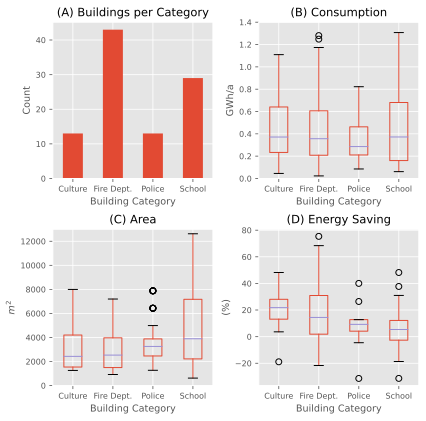

In [8]:
df = load_data_with_predictions(covid_years=True)

aa = plt.figure(figsize=(6,6))

ax = plt.subplot(2,2,1)
tmp_boxplot_df = df[['kategorie','OID']].drop_duplicates()['kategorie'].value_counts()
tmp_boxplot_df[['Culture','Fire Dept.','Police','School']].plot.bar(ax=ax,rot=0)
plt.xlabel('Building Category')
plt.ylabel('Count')
plt.title('(A) Buildings per Category')

ax = plt.subplot(2,2,2)
axs = df[['MWh/a','kategorie']].boxplot(by='kategorie',ax=ax)
axs.set_ylim([0,1.4])
axs.set_xlabel('')
axs.set_title('(B) Consumption')
axs.set_ylabel('GWh/a')
axs.set_xlabel('Building Category')
# ax.texts[0].set_text('')

ax = plt.subplot(2,2,3)
axs = df[['area','kategorie']].boxplot(by='kategorie', ax=ax)
axs.set_ylim([0,13e3])
# axs.set_xlabel('')
axs.set_title('(C) Area')
axs.set_ylabel('$m^2$')
axs.set_xlabel('Building Category')

ax = plt.subplot(2,2,4)
axs = df_savings.loc[:,['category', 'true_saving']].boxplot(by='category', ax=ax)
# axs.set_ylim([0,13e3])
# axs.set_xlabel('')
axs.set_title('(D) Energy Saving')
axs.set_ylabel('(%)')
axs.set_xlabel('Building Category')


aa.texts[0].set_text('')
plt.tight_layout()

plt.savefig('dataset.pdf')

In [9]:
df_savings

,OID,category,consumption_with_egain,consumption_without_egain,predicted_consumption_with_egain_ag,predicted_consumption_with_egain_bbsr_a,predicted_consumption_with_egain_bbsr_o,true_saving,predicted_saving_ag,predicted_saving_bbsr_a,predicted_saving_bbsr_o
0,217601,School,897050.932905,826072.953510,858983.923928,771735.054728,793494.429752,-8.592217,-3.984027,6.577857,3.943783
1,218946,School,774510.871680,878568.444000,839364.803222,691614.073097,697141.534711,11.843992,4.462218,21.279432,20.650287
2,218968,School,463081.218776,432899.986680,445471.775700,488569.912428,461875.588850,-6.971872,-2.904086,-12.859766,-6.693371
3,218972,School,120618.519294,127849.696920,130164.781784,186837.336759,146538.841442,5.655999,-1.810786,-46.138271,-14.618059
4,220065,Fire Dept.,267063.097754,284986.755598,275253.185106,154444.300508,220255.367271,6.289295,3.415447,45.806499,22.713823
...,...,...,...,...,...,...,...,...,...,...,...
90,222829,School,357509.758320,359868.571200,389687.181800,396807.076085,360679.286251,0.655465,-8.285972,-10.264443,-0.225281
91,226835,School,67185.294619,107887.385336,97643.454748,267873.507302,225682.181968,37.726459,9.495022,-148.289924,-109.183104
92,232685,Fire Dept.,218748.422390,221637.792967,220942.409100,158812.544985,227749.878823,1.303645,0.313748,28.345909,-2.757691
93,236919,Culture,252365.224190,371661.304233,334012.943314,375778.930237,444010.762135,32.098063,10.129750,-1.107897,-19.466503


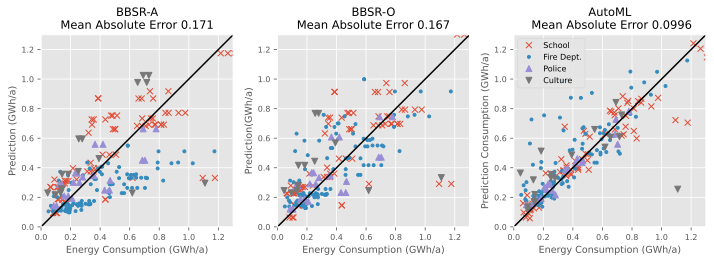

In [10]:
results_df = load_data_with_predictions().dropna(subset=['autogluon_prediction'])

mae_ag = mean_absolute_error(results_df['kWh_bereinigt'], results_df['autogluon_prediction']) / 1e6
mae_din = mean_absolute_error(results_df['kWh_bereinigt'], results_df['prediction_bbsr_a'])  / 1e6
mae_din_new = mean_absolute_error(results_df['kWh_bereinigt'], results_df['prediction_bbsr_o'])  / 1e6

symbols = ('x','.','^','v')

plt.figure(figsize=(10,4))
lim = 1.3
plt.subplot(1,3,1)
for sym, cat in zip(symbols, results_df['kategorie'].unique()):
    idx = results_df['kategorie'] == cat
    plt.plot(results_df.loc[idx,'MWh/a'],results_df.loc[idx,'prediction_bbsr_a']/1e6,sym)
plt.axis('square')
plt.ylim([0,lim])
plt.xlim([0,lim])
plt.plot([0,lim],[0,lim],'k-')
plt.xlabel('Energy Consumption (GWh/a)')
plt.ylabel('Prediction (GWh/a)')
plt.title(f'BBSR-A\nMean Absolute Error {mae_din:0.3}')

plt.subplot(1,3,2)
for sym, cat in zip(symbols, results_df['kategorie'].unique()):
    idx = results_df['kategorie'] == cat
    plt.plot(results_df.loc[idx,'MWh/a'],results_df.loc[idx,'prediction_bbsr_o']/1e6,sym)
plt.axis('square')
plt.ylim([0,lim])
plt.xlim([0,lim])
plt.plot([0,lim],[0,lim],'k-')
plt.xlabel('Energy Consumption (GWh/a)')
plt.ylabel('Prediction(GWh/a)')
plt.title(f'BBSR-O\nMean Absolute Error {mae_din_new:0.3}')


plt.subplot(1,3,3)
for sym, cat in zip(symbols, results_df['kategorie'].unique()):
    idx = results_df['kategorie'] == cat
    plt.plot(results_df.loc[idx,'MWh/a'],results_df.loc[idx,'autogluon_prediction']/1e6,sym)
plt.axis('square')
plt.ylim([0,lim])
plt.xlim([0,lim])
plt.plot([0,lim],[0,lim],'k-')
plt.xlabel('Energy Consumption (GWh/a)')
plt.ylabel('Prediction Consumption (GWh/a)')
plt.legend(results_df['kategorie'].unique())
plt.title(f'AutoML\n Mean Absolute Error {mae_ag:0.3}')

plt.tight_layout()
plt.savefig('prediction_quality_comparison_scatter.pdf')

In [11]:
results_df = load_data_with_predictions(covid_years=True).dropna(subset=['autogluon_prediction'])
# results_df = load_data_with_predictions('building_data_prediction.csv').dropna(subset=['autogluon_prediction'])
# results_df = load_data_with_predictions('building_data_prediction_new-ag-5mins.csv').dropna(subset=['autogluon_prediction'])
errors = []

for cat in results_df['kategorie'].unique():
    idx = results_df['kategorie']==cat
    mape_ag = mean_absolute_percentage_error(results_df.loc[idx,'kWh_bereinigt'], results_df.loc[idx,'autogluon_prediction'])
    mape_din = mean_absolute_percentage_error(results_df.loc[idx,'kWh_bereinigt'], results_df.loc[idx,'prediction_bbsr_a'])
    mape_din_new = mean_absolute_percentage_error(results_df.loc[idx,'kWh_bereinigt'], results_df.loc[idx,'prediction_bbsr_o'])
    mae_ag = mean_absolute_error(results_df.loc[idx,'kWh_bereinigt'], results_df.loc[idx,'autogluon_prediction'])
    mae_din = mean_absolute_error(results_df.loc[idx,'kWh_bereinigt'], results_df.loc[idx,'prediction_bbsr_a'])
    mae_din_new = mean_absolute_error(results_df.loc[idx,'kWh_bereinigt'], results_df.loc[idx,'prediction_bbsr_o'])

    errors.append([int(mae_din), int(mae_din_new), int(mae_ag), np.round(mape_din,2), np.round(mape_din_new,2), np.round(mape_ag,2)])

errors_df = pd.DataFrame(errors,index=results_df['kategorie'].unique(),columns=['MAE BBSR-A', 'MAE BBSR-O', 'MAE AutoML', 'MAPE BBSR-A', 'MAPE BBSR-O', 'MAPE AutoML'])
errors_df.loc['Mean',:] = errors_df.mean(axis=0).round(decimals=0).values
print(errors_df[['MAE BBSR-A', 'MAE BBSR-O', 'MAE AutoML']].astype(int).to_latex())

mae_ag = mean_absolute_error(results_df['kWh_bereinigt'], results_df['autogluon_prediction'])
mae_bbsr_a = mean_absolute_error(results_df['kWh_bereinigt'], results_df['prediction_bbsr_a'])
mae_bbsr_o = mean_absolute_error(results_df['kWh_bereinigt'], results_df['prediction_bbsr_o'])
print(f'MAE BBSR-A {mae_bbsr_a:0.2f}, MAE BBSR-O {mae_bbsr_o:0.2f} MAE autogluon {mae_ag:0.2f}')

\begin{tabular}{lrrr}
\toprule
{} &  MAE BBSR-A &  MAE BBSR-O &  MAE AutoML \\
\midrule
School     &      156697 &      150102 &       71109 \\
Fire Dept. &      156521 &      122545 &      106553 \\
Police     &      106684 &      103978 &       38904 \\
Culture    &      375970 &      541350 &      236521 \\
Mean       &      198968 &      229494 &      113272 \\
\bottomrule
\end{tabular}

MAE BBSR-A 170927.15, MAE BBSR-O 166741.64 MAE autogluon 99564.76


In [12]:
from sklearn.decomposition import PCA

from shutil import rmtree
import itertools

rmtree('AutogluonModels',ignore_errors=True)

n_components = 1
n_samples = 100

df = load_data_with_predictions()
df

features_building = ['OID','energietraeger', 'area', 'kategorie', 'has_egain']
features_weather     = ['KF', 'TM', 'SO', 'NM', 'FM', 'RFM']
features = features_building + features_weather
target = ["kWh"]

pca = PCA(n_components = n_components, whiten=True).fit(df[features_weather].drop_duplicates().values)
print(f'Explained Variance Ratio with {n_components}: {pca.explained_variance_ratio_}')

latents = np.linspace(-5, 5, n_samples)
synthesized_weather = pca.inverse_transform(np.array(latents).reshape(len(latents),1))

comparison_syn_real = pd.DataFrame(
                        [
                        synthesized_weather.min(axis=0),
                        df[features_weather].values.min(axis=0),
                        synthesized_weather.max(axis=0),
                        df[features_weather].values.max(axis=0)],
                        columns = features_weather,
                        index = ['syn_min','real_min','syn_max','real_max'])
comparison_syn_real

Explained Variance Ratio with 1: [0.80846074]


,KF,TM,SO,NM,FM,RFM
syn_min,1.072074,4.630890,3.359253,-11.518817,2.632787,66.735617
real_min,1.080375,5.148837,2.646008,0.000000,3.573362,74.783045
syn_max,1.207300,8.290817,3.528770,17.382479,5.555074,90.555631
real_max,1.197433,7.727160,4.448068,6.393874,4.540221,83.307935


		`import lightgbm` failed. If you are using Mac OSX, Please try 'brew install libomp'. Detailed info: dlopen(/Users/felix/opt/anaconda3/envs/pwh/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <FB7AB1B4-24FD-362B-99F0-01E20F36C929> /Users/felix/opt/anaconda3/envs/pwh/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)
		`import lightgbm` failed. If you are using Mac OSX, Please try 'brew install libomp'. Detailed info: dlopen(/Users/felix/opt/anaconda3/envs/pwh/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/li

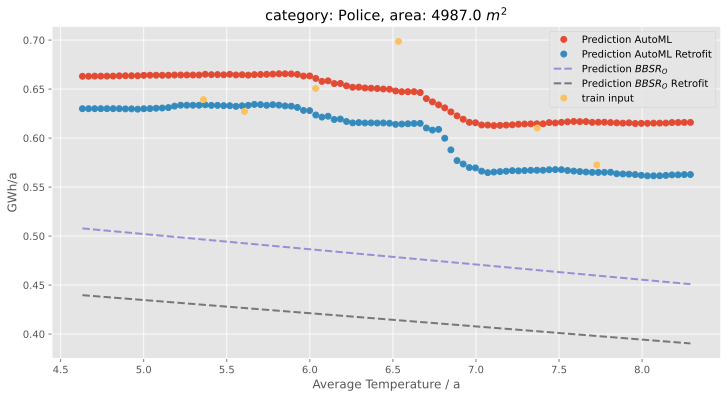

In [13]:
df = load_data_with_predictions()

# building_id = 217601 230717
target = ['kWh']

import matplotlib.pyplot as plt
plt.style.use('ggplot')
# %config InlineBackend.figure_formats = ['svg']
# %config InlineBackend.figure_format = 'svg'
import matplotlib

matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['figure.figsize'] = [12,6]

# for building_id in df['OID'].unique():
building_id = 230717

# let's first discard all information on this building
train_df = df[df['OID'] != building_id]

# Now let's assume we get the relevant building information from the Web UI
idx = df['OID']==building_id

# first let's extract the area
area = df.loc[idx, 'area'].to_list()[0]

# now let's extract the building type
category = df.loc[idx, 'kategorie'].to_list()[0]
energietraeger = df.loc[idx, 'energietraeger'].to_list()[0]

# now extract the year and corresponding consumption
years_and_kWh = df.loc[idx, ['year', 'kWh']]

# let's first remove the rows that we're pretending to be user input
train_df_db = df.loc[df['OID']!=building_id, features + target]
train_df_db


# now let's rebuild the training data from user input and weather variables from our DB
train_data_user_input = []
for _, row in years_and_kWh.iterrows():
    print()
    tmp_df_weather = df.loc[df['year']==row['year'], features_weather].head(n=1).reset_index(drop=True)
    tmp_df = pd.concat([
                pd.Series([building_id], name='OID'),
                pd.Series([area], name='area'),
                pd.Series([category], name='kategorie'),
                pd.Series([False], name='has_egain'),
                pd.Series([energietraeger], name='energietraeger'),
                pd.Series([row['kWh']], name='kWh'),
                tmp_df_weather], axis=1)
    train_data_user_input.append(
        tmp_df
    )

train_df = pd.concat([pd.concat(train_data_user_input), train_df_db])
train_df[features + target]


weather = pd.DataFrame(synthesized_weather, columns = features_weather)
sampled_df = pd.concat([
                pd.Series([None]*len(weather), name='kWh'),
                pd.Series([building_id]*len(weather), name='OID'),
                pd.Series([area]*len(weather), name='area'),
                pd.Series([category]*len(weather), name='kategorie'),
                pd.Series([True]*len(weather), name='has_egain'),
                pd.Series([energietraeger]*len(weather), name='energietraeger'),
                weather],axis=1)
sampled_df = pd.concat([sampled_df, sampled_df],axis=0,ignore_index=True)
sampled_df.loc[:len(weather)-1,'has_egain'] = False
# sampled_df
test_df = sampled_df.copy()

pred = TabularPredictor(label=target[0],
                         problem_type='regression',
                         verbosity=0)\
                         .fit(train_data=train_df[features+target],
                                                    time_limit=10,
                              presets='best_quality')
test_df['autogluon_prediction'] = pred.predict(test_df)

rmtree('AutogluonModels')

plt.figure()

plt.plot(
    test_df.loc[test_df['has_egain']==False,'TM'],
    test_df.loc[test_df['has_egain']==False,'autogluon_prediction']/1e6,'o')
plt.plot(
    test_df.loc[test_df['has_egain']==True,'TM'],
    test_df.loc[test_df['has_egain']==True,'autogluon_prediction']/1e6,'o')


coldest = weather[weather['TM']==weather['TM'].min()]
warmest = weather[weather['TM']==weather['TM'].max()]

plt.plot(
    [coldest['TM'], warmest['TM']], 
    [df.loc[(df['OID']==building_id) &  (df['has_egain']==False),'prediction_bbsr_o'].values[0]/(1e6 * coldest['KF']),
     df.loc[(df['OID']==building_id) &  (df['has_egain']==False),'prediction_bbsr_o'].values[0]/(1e6 * warmest['KF']) 
    ],'--')

plt.plot(
    [coldest['TM'], warmest['TM']], 
    [df.loc[(df['OID']==building_id) &  (df['has_egain']==True),'prediction_bbsr_o'].values[0]/(1e6 * coldest['KF']),
     df.loc[(df['OID']==building_id) &  (df['has_egain']==True),'prediction_bbsr_o'].values[0]/(1e6 * warmest['KF']) 
    ],'--')

plt.plot(
    train_df.loc[train_df['OID']==building_id,'TM'],
    train_df.loc[train_df['OID']==building_id,'kWh']/(1e6),'o')

plt.legend(['Prediction AutoML','Prediction AutoML Retrofit','Prediction $BBSR_O$','Prediction $BBSR_O$ Retrofit', 'train input'])
plt.xlabel('Average Temperature / a')
plt.ylabel('GWh/a')
plt.title(f'category: {category}, area: {area} $m^2$')
plt.savefig(f'synth_weather_{category}_{building_id}_{area}.pdf')